In [1]:
import jax
import jax.numpy as jnp
from enum import IntEnum
from memo import memo

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, fixed
import ipywidgets as widgets
import warnings


In [2]:
#class A(IntEnum): Low=0; Medium=1; High=2
#class Friend(IntEnum): Indiferent=0; Friend=1

class Confidence(IntEnum): Low=0; High=1
class Quality(IntEnum): Low=0; High=1

offers = 100*jnp.linspace(1, 5, num=5)

@jax.jit
def price_given_quality(q):
    return jnp.array([200, 400])[q]

@jax.jit
def uncertainty_given_confidence(c):
    return 100*jnp.array([1.5, .5])[c]

@jax.jit
def offer_given_confidence_quality(o, c, q):
    return jax.scipy.stats.norm.pdf(o, loc=price_given_quality(q), scale=uncertainty_given_confidence(c))

p_offer = jax.vmap(
    jax.vmap(offer_given_confidence_quality, in_axes=(None, 0, None)), in_axes=(None, None, 0)
)(offers, jnp.array([0, 1]), jnp.array([0, 1]))
p_offer /= p_offer.sum()
p_offer.round(2)

Array([[[0.06, 0.07, 0.06, 0.03, 0.01],
        [0.03, 0.22, 0.03, 0.  , 0.  ]],

       [[0.01, 0.03, 0.06, 0.07, 0.06],
        [0.  , 0.  , 0.03, 0.22, 0.03]]], dtype=float32)

### Plotting the naive response

In [4]:
# type: ignore

@jax.jit
def get_beta_prior(q, case):
    return jnp.array([
        [1, 1],  # Unsure
        [4, 1],  # Low competence / Bad quality
        [1, 4],  # High competence / Good quality
    ])[case, q]

@jax.jit
def get_min(a, b):
    return jnp.minimum(a, b)

@jax.jit
def get_max(a, b):
    return jnp.maximum(a, b)

@memo
def auctioneer_makes_offer[o: offers, c: Confidence, q: Quality](prior_q, prior_c, honesty, trustworthiness, perceived_care, disappointment, elation):

    auctioneer: knows(c, q)

    auctioneer: thinks [
        painter: knows(q),
        painter: thinks [
            auctioneer: given(q in Quality, wpp=get_beta_prior(q, prior_q)),
            auctioneer: given(c in Confidence, wpp=get_beta_prior(c, prior_c)),
            auctioneer: given(o in offers, wpp=offer_given_confidence_quality(o, c, q))
        ],
        #painter: given(observed_q in Quality, wpp=Pr[auctioneer.q == observed_q])
    ]
    auctioneer: chooses(o in offers, wpp=exp(
                        + honesty * log(offer_given_confidence_quality(o, c, q)) # Honesty / naive response
                        + imagine [
                            painter: observes [auctioneer.o] is o,
                            + trustworthiness * log(painter[Pr[auctioneer.q == q]])
                            + perceived_care * log(painter[E[auctioneer.q]])
                            - disappointment * log(abs(get_min(1e-8, q - painter[E[auctioneer.q]])))
                            + elation * log(get_max(1e-8, q - painter[E[auctioneer.q]]))
                        ]
                    ))

    return Pr[auctioneer.o == o]

honesty = 1
trustworthiness = 1
perceived_care = 0
disappointment = 0
elation = 0
prior_quality = 0
prior_confidence = 0

auctioneer_makes_offer(prior_quality, prior_confidence, honesty, trustworthiness, perceived_care, disappointment, elation)[:, Confidence.Low, Quality.Low].round(2)


Array([0.35      , 0.42999998, 0.19      , 0.02      , 0.01      ],      dtype=float32)

In [7]:



# Create custom widgets with sufficient width for descriptions
def create_labeled_dropdown(options, description, value=None):
    # Convert options to display both value and name
    labeled_options = [(f"{option.name} ({option.value})", option) for option in options]
    
    # Create dropdown with style to accommodate longer descriptions
    dropdown = widgets.Dropdown(
        options=labeled_options, 
        description=description,
        value=value,
        style={'description_width': 'auto'}  # This allows description to use needed space
    )
    
    # Set layout to provide more space
    dropdown.layout.width = '50%'  # Use full width
    
    return dropdown

class QualityBelief(IntEnum): Unsure=0; Low=1; High=2
class ConfidenceBelief(IntEnum): Unsure=0; Low=1; High=2
prior_quality_widget = create_labeled_dropdown(QualityBelief, "Prior Quality:", value=Quality.Low)
prior_quality_widget.layout.width = '50%'
prior_confidence_widget = create_labeled_dropdown(ConfidenceBelief, "Prior Confidence:", value=Confidence.Low)
prior_confidence_widget.layout.width = '50%'

honesty_widget = widgets.FloatSlider(value=1, min=0, max=2, step=0.1, description='Honesty:', style={'description_width': 'auto'})
honesty_widget.layout.width = '50%'
trustworthiness_widget = widgets.FloatSlider(value=1, min=0, max=2, step=0.1, description='Trustworthiness:', style={'description_width': 'auto'})
trustworthiness_widget.layout.width = '50%'
perceived_care_widget = widgets.FloatSlider(value=0, min=0, max=2, step=0.1, description='Perceived Care', style={'description_width': 'auto'})
perceived_care_widget.layout.width = '50%'
disappointment_widget = widgets.FloatSlider(value=0, min=0, max=2, step=0.1, description='Disappointment:', style={'description_width': 'auto'})
disappointment_widget.layout.width = '50%'
elation_widget = widgets.FloatSlider(value=0, min=0, max=2, step=0.1, description='Elation:', style={'description_width': 'auto'})
elation_widget.layout.width = '50%'


def show_interactive_plot(prior_quality, prior_confidence, honesty, trustworthiness, perceived_care, disappointment, elation):
    plt.close('all')


    fig , axes = plt.subplots(len(Confidence), len(Quality), figsize=(8, 7), sharex=True, sharey=True)

    for c in Confidence:
        for q in Quality:
            ax = axes[c, q]
            df = pd.DataFrame({
                'Offer': offers.round(),
                'Probability': auctioneer_makes_offer(prior_quality, prior_confidence, honesty, trustworthiness, perceived_care, disappointment, elation)[:, c, q]
            })
            sns.barplot(data=df, x='Offer', y='Probability', ax=ax)
            #ax.set_title(f'Confidence: {Confidence(c).name}, Quality: {Quality(q).name}')
            ax.set_ylim(0, 1)
            ax.set_xlabel('Offer ($)', fontsize=15)
            ax.tick_params(axis='both', which='major', labelsize=17)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax.set_xticklabels(offers.astype(int), rotation=0)



            ax.set_ylabel(f'Auctioneer confidence\n{c.name.title()}', fontsize=17)   
            if c == 0:
                ax.set_title(f'Painting quality\n{q.name.title()}=\${price_given_quality(q)}', fontsize=17)

    fig.suptitle('Auctioneer p(offer | confidence, quality)', fontsize=20)
    sns.despine()
    plt.tight_layout()
    plt.show()

def show_interactive_plot_fixed(prior_quality, honesty, trustworthiness, perceived_care, disappointment, elation):
    show_interactive_plot(prior_quality, 0, honesty, trustworthiness, perceived_care, disappointment, elation)
interact(
    show_interactive_plot,
    prior_quality=prior_quality_widget,
    prior_confidence=prior_confidence_widget,
    honesty=honesty_widget,
    trustworthiness=trustworthiness_widget,
    perceived_care=perceived_care_widget,
    disappointment=disappointment_widget,
    elation=elation_widget
)


interactive(children=(Dropdown(description='Prior Quality:', layout=Layout(width='50%'), options=(('Unsure (0)…

<function __main__.show_interactive_plot(prior_quality, prior_confidence, honesty, trustworthiness, perceived_care, disappointment, elation)>

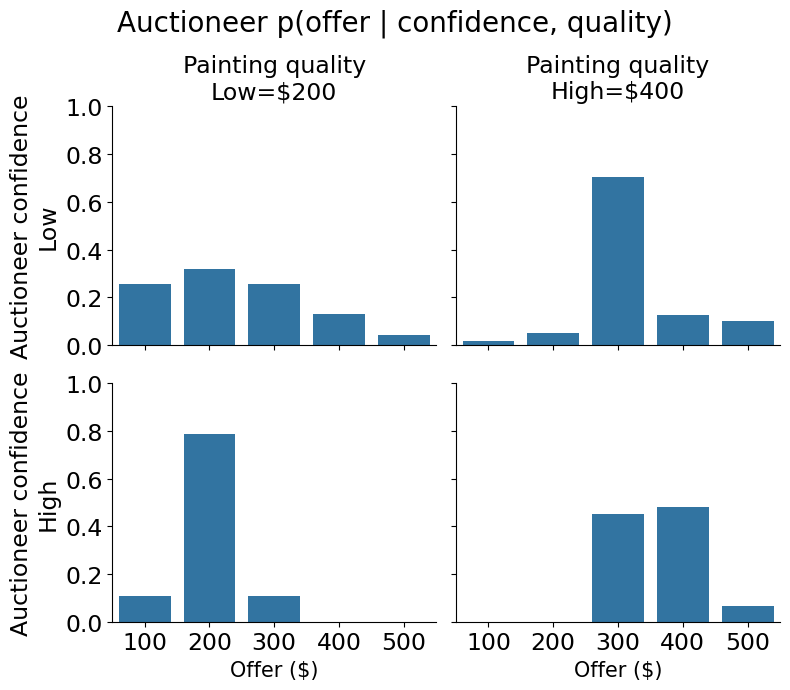

In [9]:


def plot_p_offers(honesty, trustworthiness, perceived_care, disappointment, elation, save_fig=False, close_fig=False):
    fig, axes = plt.subplots(2, 2, figsize=(8, 7), sharex=True, sharey=True)
    
    for c in Confidence:
        for q in Quality:
            ax = axes[c, q]
            df = pd.DataFrame({
                'Offer': offers.round(),
                'Probability': auctioneer_makes_offer(0, 0, honesty, trustworthiness, perceived_care, disappointment, elation)[:, c, q]
            })
            sns.barplot(data=df, x='Offer', y='Probability', ax=ax)
            #ax.set_title(f'Confidence: {Confidence(c).name}, Quality: {Quality(q).name}')
            ax.set_ylim(0, 1)
            ax.set_xlabel('Offer ($)', fontsize=15)
            ax.tick_params(axis='both', which='major', labelsize=17)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax.set_xticklabels(offers.astype(int), rotation=0)

            ax.set_ylabel(f'Auctioneer confidence\n{c.name.title()}', fontsize=17)   
            if c == 0:
                ax.set_title(f'Painting quality\n{q.name.title()}=${price_given_quality(q)}', fontsize=17)

    fig.suptitle(f'Auctioneer p(offer | confidence, quality)', fontsize=20)
    sns.despine()
    plt.tight_layout()

    if save_fig:
        fig.savefig(f'figures/{save_fig}.png', dpi=300)
    if close_fig:
        plt.close(fig)
    else:
        plt.show()
    
    return fig

# Base case
honesty = 1
trustworthiness = 0
perceived_care = 0
disappointment = 0
elation = 0
fig_name = f"honesty={honesty}_trustworthiness={trustworthiness}_perceivedcare={perceived_care}_disappointment={disappointment}_elation={elation}"
plot_p_offers(honesty, trustworthiness, perceived_care, disappointment, elation, save_fig=fig_name, close_fig=True)

# Trustworthy case
honesty = 1
trustworthiness = 0
perceived_care = 2
disappointment = 2
elation = 2
fig_name = f"honesty={honesty}_trustworthiness={trustworthiness}_perceivedcare={perceived_care}_disappointment={disappointment}_elation={elation}"
plot_p_offers(honesty, trustworthiness, perceived_care, disappointment, elation, save_fig=fig_name, close_fig=True)